In [ ]:
%load_ext autoreload
%autoreload 2
!echo $HOSTNAME

import sys
print('Python path: ', sys.executable)

In [1]:
from pathlib import Path
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pickle

## Gathering fewshot resutls

In [2]:
fewshot_performance = np.load("tcrp_fewshot-test-correlations-corrected.npz")['arr_0']

## Gathering baselines

In [7]:
datapath = Path("../output/210803_drug-baseline-models/baseline_performances")

In [8]:
%%time

results = {}
for outer_directory in datapath.glob("*"): 
    drug = outer_directory.stem
    results[drug] = {}
    
    for inner_directory in outer_directory.glob("*"): 
        tissue = inner_directory.stem
        results[drug][tissue] = {}
        
        data = np.load(inner_directory / "baseline_performance.npz")
        
        for model in ['linear', 'KNN', 'RF']: 
            zero = data[f"{model}-zero"]
            zero = np.vstack([zero for _ in range(20)]) # There is only 1 possible zero-shot, so expanding for all trials
            performance = np.median(np.hstack([zero, data[f"{model}-fewshot"]]), axis=0)
            
            results[drug][tissue][model] = performance    

CPU times: user 11.6 ms, sys: 4.76 ms, total: 16.3 ms
Wall time: 19.2 ms


In [9]:
print(results)

{'Pelitinib': {'large_intestine': {'linear': array([0.24260145, 0.26542738, 0.27005144, 0.26897658, 0.27084133,
       0.27103202, 0.26912437, 0.26259859, 0.25877373, 0.25388304,
       0.24975556]), 'KNN': array([0.42120543, 0.39816521, 0.39989879, 0.41110576, 0.39747358,
       0.40635404, 0.41450559, 0.41451399, 0.43469571, 0.38487504,
       0.38487504]), 'RF': array([0.10113704, 0.05310196, 0.05111078, 0.05070722, 0.05739181,
       0.08982323, 0.0537044 , 0.06751961, 0.07301644, 0.04722407,
       0.07880307])}, 'oesophagus': {'linear': array([0.09123436, 0.0644874 , 0.06859072, 0.06878   , 0.07132263,
       0.06822953, 0.06474985, 0.07946947, 0.07530924, 0.07053963,
       0.07451858]), 'KNN': array([-0.03795385, -0.06559652, -0.05501306, -0.06274335, -0.11061035,
       -0.0679082 , -0.11188527, -0.11188527, -0.1200148 , -0.12034603,
       -0.14226821]), 'RF': array([-0.09737757, -0.08529335, -0.11225562, -0.11291893, -0.10238597,
       -0.06148702, -0.07444732, -0.12153841,

In [10]:
results_by_baseline = {'linear': [], 'KNN': [], 'RF': []}

for drug, d in results.items(): 
    for tissue, d in d.items(): 
        for model, p in d.items(): 
            results_by_baseline[model].append(p)
            
for model, ps in results_by_baseline.items(): 
    results_by_baseline[model] = np.vstack(ps)

## All performance

In [11]:
def get_statistics(data): 
    median = np.nanmean(data, axis=0)
    index = np.random.choice(data.shape[0], size=(data.shape[0], 1000), replace=True)
    resampled = np.nanmean(data[index], axis=0)

    low = np.nanpercentile(resampled, 2.5, axis=0)
    high = np.nanpercentile(resampled, 97.5, axis=0)
    
    ci = np.vstack([median - low, high-median])
    
    return median, ci

Text(0.5, 1.0, 'Corrected results')

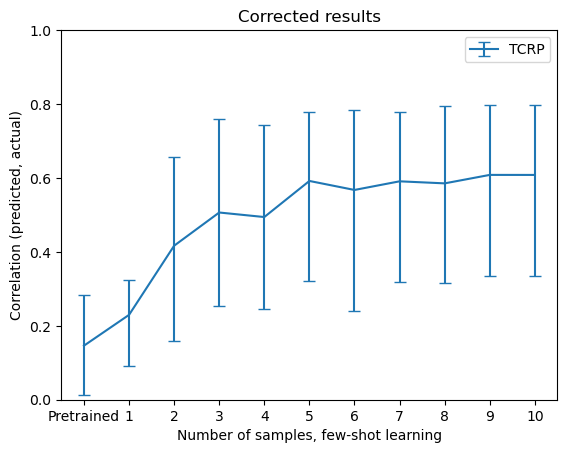

In [15]:
fig, ax = plt.subplots()

x = np.arange(11)

kwargs = {'capsize': 4}

#for model, ps in results_by_baseline.items(): 
#    median, yerr = get_statistics(ps)
#    ax.errorbar(x, median, yerr=yerr, label=model, **kwargs)
    
median, yerr = get_statistics(fewshot_performance)
ax.errorbar(x, median, yerr=yerr, label='TCRP', **kwargs)

ax.legend()
labels = ['Pretrained'] + [str(i) for i in range(1, 11)]
ax.set_xticks(np.arange(11))
ax.set_xticklabels(labels)

ax.set_ylim([0, 1])
ax.set_xlabel("Number of samples, few-shot learning")
ax.set_ylabel("Correlation (predicted, actual)")

ax.set_title("Corrected results")

In [ ]:
median